# 11. 항공 사진 내 선인장 식별


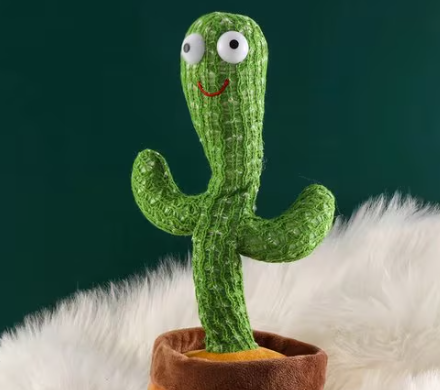

## 0. 학습순서

1. 경진대회 이해
2. 탐색적 데이터 분석 (EDA)
3. 베이스라인 모델 (얕은 CNN)
4. 성능 개선 I (깊은 CNN + 배치 정규화 + 데이터 증강)
5. 성능 개선 II (전이 학습)
6. 핵심 요약

## 1. 경진대회 이해

- 목표 : 항공 사진에서 선인장 찾기
- 배경
  - 기후 변화로 인해 자연이 지속적으로 파괴되고 있다.
  - 자연을 보호하고자 멕시코는 VIGIA 프로젝트를 진행하였다.
  - VIGIA 자연보호 구역 자율 감시를 위해 **첫 번째 단계로 보호 구역 내에 초목이 잘 자라는지 확인**한다.
  - 넓은 지대를 사람이 일일이 확인하기 어렵다.
  - 드론과 이미지 인식 기술을 결합하여 자율 감시 시스템을 개발하였다.
  - **사람의 손을 거치지 않고 보호 구역 내 초목(선인장)이 얼마나 있는지 파악**할 수 있다.

## 2. 탐색적 데이터 분석

### 2.0 환경 설정

In [1]:
# 표준 라이브러리
import os
import random
from zipfile import ZipFile

# 수학 및 데이터 처리 라이브러리
import numpy as np
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# OpenCV
import cv2

# PyTorch 관련 모듈
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
# 데이터 경로
data_path = 'C:/Users/soyun/Desktop/cactus_class/aerial-cactus-identification/'

labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

### 2.1 데이터 둘러보기

In [2]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [3]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


### 2.2 데이터 시각화

타깃값 분포 확인

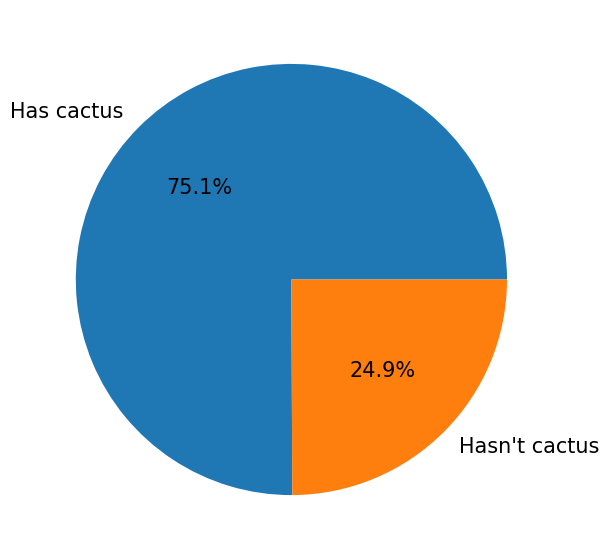

In [5]:
mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['Has cactus', 'Hasn\'t cactus'] # 타깃값 레이블
# 타깃값 분포 파이 그래프
plt.pie(labels['has_cactus'].value_counts(), labels=label, autopct='%.1f%%');

이미지 출력

In [ ]:
# 훈련 이미지 데이터 압출 풀기
with ZipFile(data_path + 'train.zip') as zipper:
    zipper.extractall()
    
# 테스트 이미지 데이터 압출 풀기
with ZipFile(data_path + 'test.zip') as zipper:
    zipper.extractall()

In [12]:
num_train = len(os.listdir('C:/Users/soyun/Desktop/cactus_class/aerial-cactus-identification/train/'))
num_test = len(os.listdir('C:/Users/soyun/Desktop/cactus_class/aerial-cactus-identification/test/'))

print(f'훈련 데이터 개수: {num_train}')
print(f'테스트 데이터 개수: {num_test}')

훈련 데이터 개수: 17500
테스트 데이터 개수: 4000


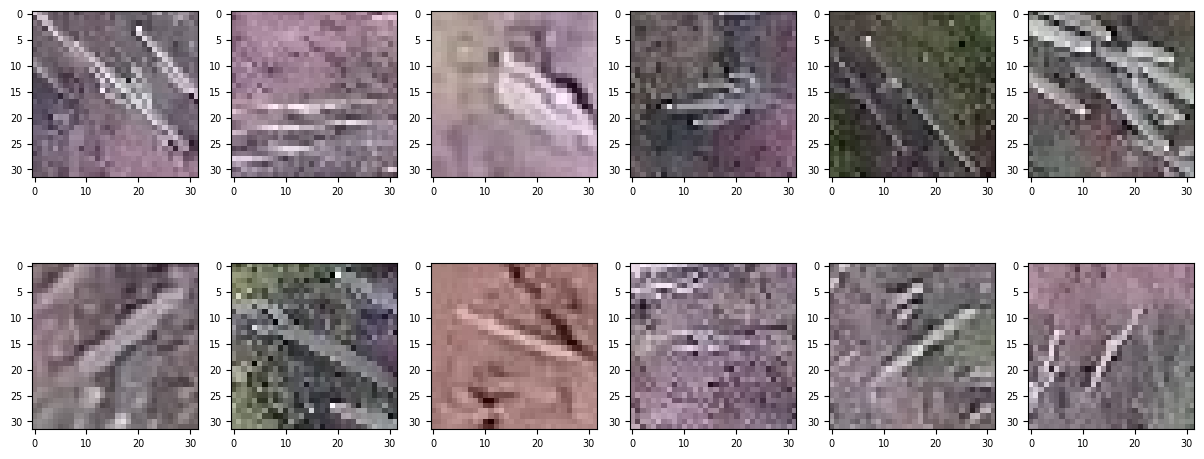

In [14]:
mpl.rc('font', size=7)
plt.figure(figsize=(15, 6))    # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 서브플롯 배치(2행 6열로 출력)
    
# 선인장을 포함하는 이미지 파일명(마지막 12개) 
last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-12:]

# 이미지 출력 
for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = 'C:/Users/soyun/Desktop/cactus_class/aerial-cactus-identification/train/' + img_name                 # 이미지 파일 경로 
    image = cv2.imread(img_path)                   # 이미지 파일 읽기 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정 
    ax = plt.subplot(grid[idx])
    ax.imshow(image)                               # 이미지 출력 

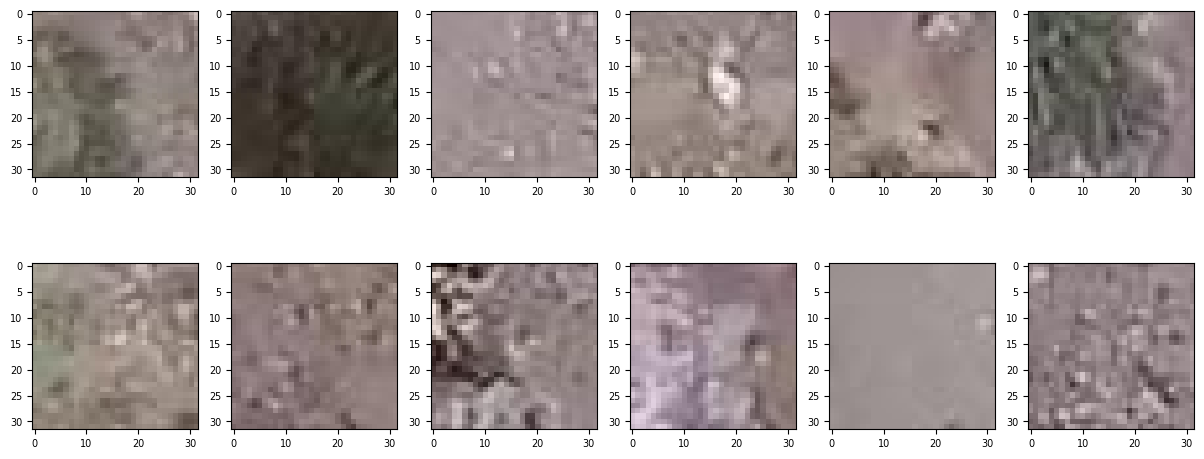

In [15]:
plt.figure(figsize=(15, 6))    # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 서브플롯 배치
    
# 선인장을 포함하지 않는 이미지 파일명(마지막 12개) 
last_hasnt_cactus_img_name = labels[labels['has_cactus']==0]['id'][-12:]

# 이미지 출력 
for idx, img_name in enumerate(last_hasnt_cactus_img_name):
    img_path = 'C:/Users/soyun/Desktop/cactus_class/aerial-cactus-identification/train/' + img_name                 # 이미지 파일 경로
    image = cv2.imread(img_path)                   # 이미지 파일 읽기
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
    ax = plt.subplot(grid[idx])
    ax.imshow(image)                               # 이미지 출력 

In [16]:
image.shape

(32, 32, 3)

## 3. 베이스라인 모델

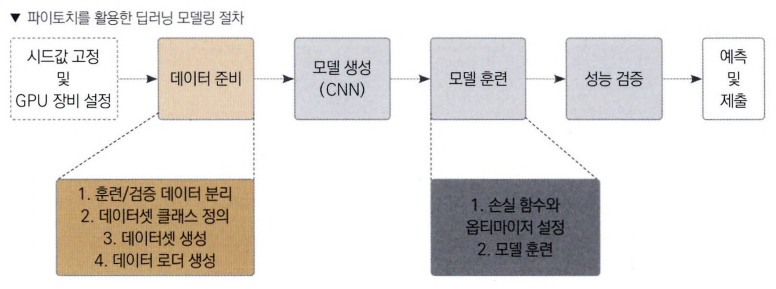

1. 시드값 고정 및 GPU 장비 설정
2. 데이터 준비
3. 모델 생성
4. 모델 훈련
5. 성능 검증
6. 예측 및 제출

### 3.1 시드값 고정 및 GPU 장비 설정

시드값 고정

In [3]:
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)                # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)             # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)          # 파이토치 난수 생성기 시드 고정 (CPU 사용 시)
torch.cuda.manual_seed(seed)     # 파이토치 난수 생성기 시드 고정 (GPU 사용 시)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티GPU 사용 시)
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False    # 벤치마크 기능 해제
torch.backends.cudnn.enabled = False      # cudnn 사용 해제

GPU 장비 설정

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
device

device(type='cuda')

### 3.2 데이터 준비

- 훈련/검증 데이터 분리
- 데이터셋 클래스 정의
- 데이터셋 생성
- 데이터 로더 생성

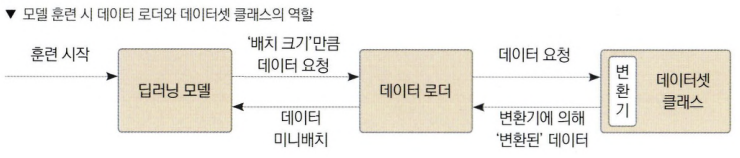

In [8]:
# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(labels, 
                                test_size=0.1,
                                stratify=labels['has_cactus'],
                                random_state=50)

In [9]:
print('훈련 데이터 개수:', len(train))
print('검증 데이터 개수:', len(valid))

훈련 데이터 개수: 15750
검증 데이터 개수: 1750


In [13]:
class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드 
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]    # 이미지 ID
        img_path = self.img_dir + img_id # 이미지 파일 경로 
        image = cv2.imread(img_path)     # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        label = self.df.iloc[idx, 1]     # 이미지 레이블(타깃값)

        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

In [15]:
# 텐서로 변환
transform = transforms.ToTensor()

In [16]:
dataset_train = ImageDataset(df=train, img_dir=data_path + 'train/', transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir=data_path + 'train/', transform=transform)

데이터 로더 생성

In [18]:
loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

### 3.3 모델 생성

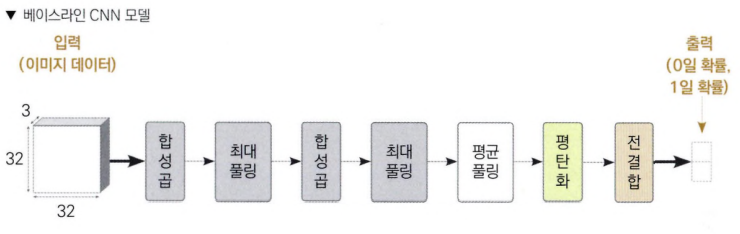

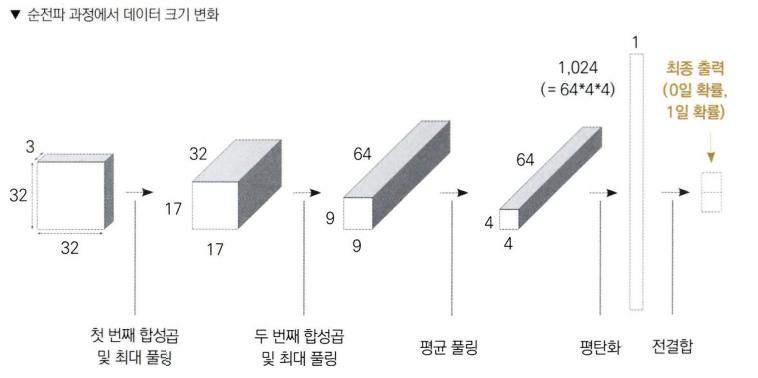

In [20]:
class Model(nn.Module):
    # 신경망 계층 정의 
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
        
        # 첫 번째 합성곱 계층 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, 
                               kernel_size=3, padding=2) 
        # 두 번째 합성곱 계층 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=3, padding=2) 
        # 최대 풀링 계층 
        self.max_pool = nn.MaxPool2d(kernel_size=2) 
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=2) 
        # 전결합 계층 
        self.fc = nn.Linear(in_features=64 * 4 * 4, out_features=2)
        
    # 순전파 출력 정의 
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 64 * 4 * 4) # 평탄화
        x = self.fc(x)
        return x

In [21]:
model = Model().to(device)

model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

### 3.4 모델 훈련

In [22]:
# 손실함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [23]:
import math

math.ceil(len(train) / 32)

493

In [24]:
len(loader_train)

493

In [31]:
epochs = 20 # 총 에폭
# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화
    
    # '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() 
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')

에폭 [1/20] - 손실값: 0.1210
에폭 [2/20] - 손실값: 0.1206
에폭 [3/20] - 손실값: 0.1187
에폭 [4/20] - 손실값: 0.1132
에폭 [5/20] - 손실값: 0.1109
에폭 [6/20] - 손실값: 0.1061
에폭 [7/20] - 손실값: 0.1075
에폭 [8/20] - 손실값: 0.1030
에폭 [9/20] - 손실값: 0.1013
에폭 [10/20] - 손실값: 0.0992
에폭 [11/20] - 손실값: 0.0986
에폭 [12/20] - 손실값: 0.0979
에폭 [13/20] - 손실값: 0.0970
에폭 [14/20] - 손실값: 0.0970
에폭 [15/20] - 손실값: 0.0922
에폭 [16/20] - 손실값: 0.0939
에폭 [17/20] - 손실값: 0.0920
에폭 [18/20] - 손실값: 0.0925
에폭 [19/20] - 손실값: 0.0914
에폭 [20/20] - 손실값: 0.0887


### 3.5 성능 검증

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수 임포트

In [32]:
# 실제값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

In [33]:
model.eval() # 모델을 평가 상태로 설정 

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device) 
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률  
        true = labels.cpu() # 실제값 
        # 예측 확률과 실제값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)
        
# 검증 데이터 ROC AUC 점수 계산
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')

검증 데이터 ROC AUC : 0.9945


### 3.6 예측 및 결과 제출

In [28]:
dataset_test = ImageDataset(df=submission, img_dir=data_path + 'test/', transform=transform)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

예측

In [29]:
model.eval() # 모델을 평가 상태로 설정

preds = [] # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

결과 제출

In [30]:
submission['has_cactus'] = preds
submission.to_csv('submission.csv', index=False)

압축이 풀린 데이터 삭제

In [ ]:
# import shutil

# shutil.rmtree('./train')
# shutil.rmtree('./test')

## 4. 성능 개선


1. 다양한 이미지 변환 수행
2. 더 깊은 CNN 모델 개발
3. 더 뛰어난 옵티마이저 사용
4. 훈련 시 에폭 수 증가


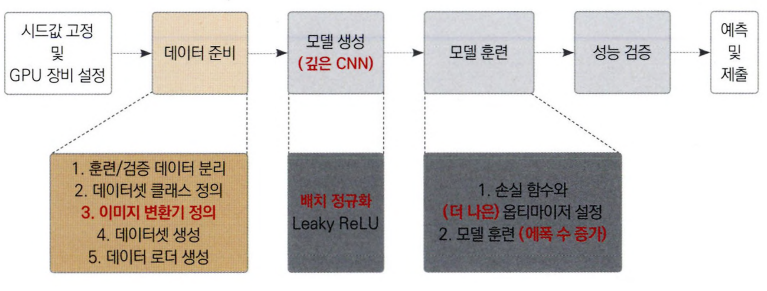

### 4.1 데이터 준비

In [13]:
# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(labels, 
                                test_size=0.1,
                                stratify=labels['has_cactus'],
                                random_state=50)

In [14]:
class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드 
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]    # 이미지 ID
        img_path = self.img_dir + img_id # 이미지 파일 경로 
        image = cv2.imread(img_path)     # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        label = self.df.iloc[idx, 1]     # 이미지 레이블(타깃값)

        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

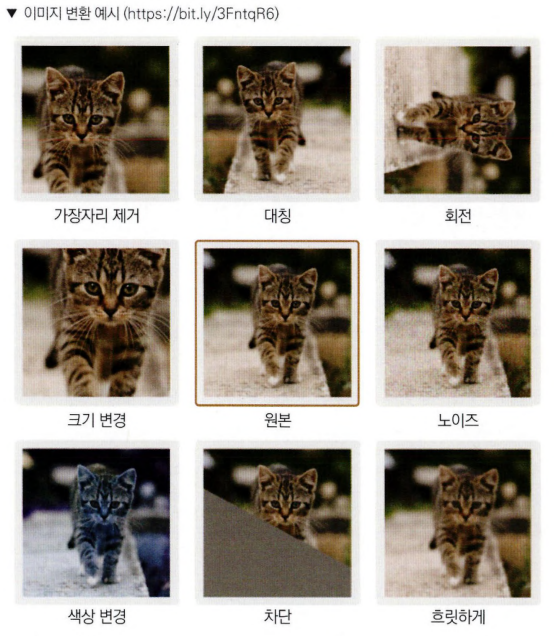

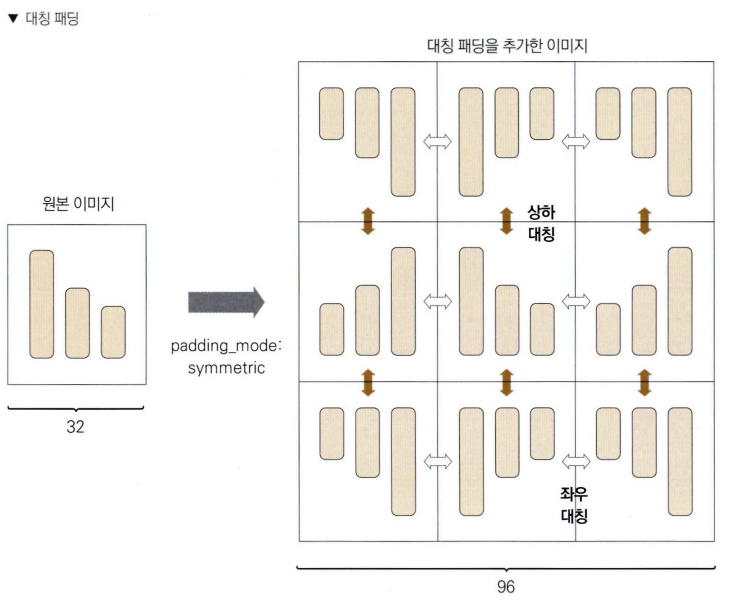

In [15]:
# 훈련 데이터용 변환기
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode='symmetric'),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

# 검증 및 테스트 데이터용 변환기
transform_test= transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(32, padding_mode='symmetric'),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])


In [16]:
dataset_train = ImageDataset(df=labels, img_dir=data_path +'train/', transform=transform_train)
dataset_valid = ImageDataset(df=valid, img_dir=data_path +'train/', transform=transform_test)

In [17]:
loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

### 4.2 모델 생성

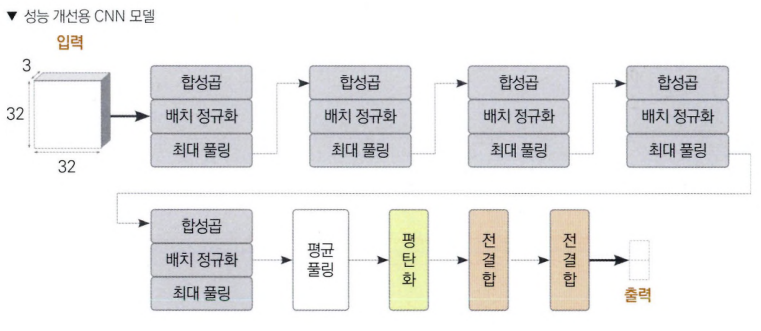

In [18]:
class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
        # 1 ~ 5번째 {합성곱, 배치 정규화, 최대 풀링} 계층 
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(32), # 배치 정규화
                                    nn.LeakyReLU(), # LeakyReLU 활성화 함수
                                    nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=4) 
        # 전결합 계층
        self.fc1 = nn.Linear(in_features=512 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=2)

    # 순전파 출력 정의 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 * 1 * 1) # 평탄화
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [19]:
model = Model().to(device)
model

Model(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128,

### 4.3 모델 훈련

In [20]:
# 손실함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저
optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)

In [21]:
epochs = 70 # 총 에폭

# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화
    
    # '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() 
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')    

에폭 [1/70] - 손실값: 0.1272
에폭 [2/70] - 손실값: 0.0645
에폭 [3/70] - 손실값: 0.0494
에폭 [4/70] - 손실값: 0.0379
에폭 [5/70] - 손실값: 0.0343
에폭 [6/70] - 손실값: 0.0300
에폭 [7/70] - 손실값: 0.0282
에폭 [8/70] - 손실값: 0.0257
에폭 [9/70] - 손실값: 0.0247
에폭 [10/70] - 손실값: 0.0224
에폭 [11/70] - 손실값: 0.0210
에폭 [12/70] - 손실값: 0.0189
에폭 [13/70] - 손실값: 0.0208
에폭 [14/70] - 손실값: 0.0184
에폭 [15/70] - 손실값: 0.0155
에폭 [16/70] - 손실값: 0.0159
에폭 [17/70] - 손실값: 0.0155
에폭 [18/70] - 손실값: 0.0152
에폭 [19/70] - 손실값: 0.0147
에폭 [20/70] - 손실값: 0.0131
에폭 [21/70] - 손실값: 0.0130
에폭 [22/70] - 손실값: 0.0111
에폭 [23/70] - 손실값: 0.0115
에폭 [24/70] - 손실값: 0.0113
에폭 [25/70] - 손실값: 0.0119
에폭 [26/70] - 손실값: 0.0105
에폭 [27/70] - 손실값: 0.0106
에폭 [28/70] - 손실값: 0.0105
에폭 [29/70] - 손실값: 0.0105
에폭 [30/70] - 손실값: 0.0092
에폭 [31/70] - 손실값: 0.0093
에폭 [32/70] - 손실값: 0.0102
에폭 [33/70] - 손실값: 0.0091
에폭 [34/70] - 손실값: 0.0092
에폭 [35/70] - 손실값: 0.0084
에폭 [36/70] - 손실값: 0.0088
에폭 [37/70] - 손실값: 0.0082
에폭 [38/70] - 손실값: 0.0072
에폭 [39/70] - 손실값: 0.0066
에폭 [40/70] - 손실값: 0.0068
에폭 [41/70

### 4.4 성능 검증


In [24]:
# 실제값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

model.eval() # 모델을 평가 상태로 설정 

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률값
        true = labels.cpu() # 실제값 
        # 예측 확률값과 실제값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)
        
# 검증 데이터 ROC AUC 점수 계산 
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')    

검증 데이터 ROC AUC : 1.0000


### 4.5 예측 및 결과 제출

예측 및 결과 제출

In [25]:
dataset_test = ImageDataset(df=submission, img_dir=data_path +'test/', 
                            transform=transform_test)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

# 예측 수행
model.eval() # 모델을 평가 상태로 설정

preds = [] # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

In [26]:
submission['has_cactus'] = preds
submission.to_csv('submission_modeling1_70.csv', index=False)

### 4.6 한 걸음 더

훈련 데이터를 9:1로 나누어 9 만큼 모델을 훈련했으나, 전체 데이터를 활용하여 모델 훈련

In [10]:
class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드 
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]    # 이미지 ID
        img_path = self.img_dir + img_id # 이미지 파일 경로 
        image = cv2.imread(img_path)     # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        label = self.df.iloc[idx, 1]     # 이미지 레이블(타깃값)

        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

In [11]:
# 훈련 데이터용 변환기
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode='symmetric'),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

# 검증 및 테스트 데이터용 변환기
transform_test= transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(32, padding_mode='symmetric'),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])

In [12]:
dataset_train = ImageDataset(df=labels, img_dir=data_path + 'train/', transform=transform_train)
dataset_valid = ImageDataset(df=valid, img_dir=data_path + 'train/', transform=transform_test)

In [13]:
loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

In [14]:
class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
        # 1 ~ 5번째 {합성곱, 배치 정규화, 최대 풀링} 계층 
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(32), # 배치 정규화
                                    nn.LeakyReLU(), # LeakyReLU 활성화 함수
                                    nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=4) 
        # 전결합 계층
        self.fc1 = nn.Linear(in_features=512 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=2)

    # 순전파 출력 정의 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 * 1 * 1) # 평탄화
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [15]:
model = Model().to(device)
model

Model(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128,

In [16]:
# 손실함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저
optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)

In [17]:
epochs = 70 # 총 에폭

# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화
    
    # '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() 
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')  

에폭 [1/70] - 손실값: 0.1272
에폭 [2/70] - 손실값: 0.0645
에폭 [3/70] - 손실값: 0.0494
에폭 [4/70] - 손실값: 0.0379
에폭 [5/70] - 손실값: 0.0343
에폭 [6/70] - 손실값: 0.0300
에폭 [7/70] - 손실값: 0.0282
에폭 [8/70] - 손실값: 0.0257
에폭 [9/70] - 손실값: 0.0247
에폭 [10/70] - 손실값: 0.0224
에폭 [11/70] - 손실값: 0.0210
에폭 [12/70] - 손실값: 0.0189
에폭 [13/70] - 손실값: 0.0208
에폭 [14/70] - 손실값: 0.0184
에폭 [15/70] - 손실값: 0.0155
에폭 [16/70] - 손실값: 0.0159
에폭 [17/70] - 손실값: 0.0155
에폭 [18/70] - 손실값: 0.0152
에폭 [19/70] - 손실값: 0.0147
에폭 [20/70] - 손실값: 0.0131
에폭 [21/70] - 손실값: 0.0130
에폭 [22/70] - 손실값: 0.0111
에폭 [23/70] - 손실값: 0.0115
에폭 [24/70] - 손실값: 0.0113
에폭 [25/70] - 손실값: 0.0119
에폭 [26/70] - 손실값: 0.0105
에폭 [27/70] - 손실값: 0.0106
에폭 [28/70] - 손실값: 0.0105
에폭 [29/70] - 손실값: 0.0105
에폭 [30/70] - 손실값: 0.0092
에폭 [31/70] - 손실값: 0.0093
에폭 [32/70] - 손실값: 0.0102
에폭 [33/70] - 손실값: 0.0091
에폭 [34/70] - 손실값: 0.0092
에폭 [35/70] - 손실값: 0.0084
에폭 [36/70] - 손실값: 0.0088
에폭 [37/70] - 손실값: 0.0082
에폭 [38/70] - 손실값: 0.0072
에폭 [39/70] - 손실값: 0.0066
에폭 [40/70] - 손실값: 0.0068
에폭 [41/70

In [18]:
# 실제값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

model.eval() # 모델을 평가 상태로 설정 

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률값
        true = labels.cpu() # 실제값 
        # 예측 확률값과 실제값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)
        
# 검증 데이터 ROC AUC 점수 계산 
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')    

검증 데이터 ROC AUC : 1.0000


In [19]:
dataset_test = ImageDataset(df=submission, img_dir=data_path + 'test/', 
                            transform=transform_test)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

# 예측 수행
model.eval() # 모델을 평가 상태로 설정

preds = [] # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

In [20]:
submission['has_cactus'] = preds
submission.to_csv('submission_modeling2_70.csv', index=False)

## 5. 전이 학습

- 사전 훈련된 모델에 약간의 추가 학습을 더해 유사한 다른 문제에 적용
- 학습 시간이 단축되고, 성능도 더 뛰어남

### 5.1 데이터 준비

In [6]:
# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(labels, 
                                test_size=0.1,
                                stratify=labels['has_cactus'],
                                random_state=50)

In [7]:
print('훈련 데이터 개수:', len(train))
print('검증 데이터 개수:', len(valid))

훈련 데이터 개수: 15750
검증 데이터 개수: 1750


In [8]:
class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드 
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]    # 이미지 ID
        img_path = self.img_dir + img_id # 이미지 파일 경로 
        image = cv2.imread(img_path)     # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        label = self.df.iloc[idx, 1]     # 이미지 레이블(타깃값)

        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

In [9]:
# 훈련 데이터용 변환기
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode='symmetric'),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

# 검증 및 테스트 데이터용 변환기
transform_test= transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(32, padding_mode='symmetric'),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])

In [10]:
dataset_train = ImageDataset(df=labels, img_dir=data_path +'train/', transform=transform_train)
dataset_valid = ImageDataset(df=valid, img_dir=data_path +'train/', transform=transform_test)

In [11]:
loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

### 5.2 모델 생성

주요 사전 학습 모델

- **VGG** : models.vgg16(pretrained=True)
- **EfficientNet** : models.efficientnet_b0(pretrained=True)
- **DenseNet** : models.densenet121(pretrained=True)
- **Vision Transformer (ViT)** : torchvision.models.vit_b_16(pretrained=True)

In [12]:
class PretrainedModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # ResNet18 사전학습 모델 로드
        self.base_model = models.resnet18(pretrained=True)
        
        # 마지막 fully connected layer를 제거하여 특징 추출용으로 사용
        num_features = self.base_model.fc.in_features  # ResNet18의 마지막 FC layer 입력 크기
        self.base_model.fc = nn.Identity()  # 마지막 FC layer 제거 (특징 추출)
        
        # 새로운 FC 계층 추가
        self.fc1 = nn.Linear(num_features, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
        # 활성화 함수
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # ResNet18에서 특징 추출
        x = self.base_model(x)
        
        # 새로운 FC 계층 통과
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# # 데이터 전처리 (예: ImageNet 정규화)
# from torchvision import transforms
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # ResNet 입력 크기에 맞게 조정
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # 가중치 학습 동결 (필요시)
# for param in model.base_model.parameters():
#     param.requires_grad = False  # 사전학습된 가중치는 고정
    
# # 학습 단계에서 새로운 FC 계층만 학습
# optimizer = torch.optim.Adam(model.fc1.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()


In [13]:
model = PretrainedModel(num_classes=2).to(device)  # 모델 초기화

C:\Users\soyun\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\soyun\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\soyun/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 61.8MB/s]


In [20]:
model

PretrainedModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

### 5.3 모델 훈련

In [14]:
# 사전학습된 가중치 동결
for param in model.base_model.parameters():
    param.requires_grad = False  # ResNet18의 기본 가중치는 고정

In [15]:
# 손실 함수
criterion = nn.CrossEntropyLoss()
# 학습 단계에서 새로운 FC 계층만 학습
optimizer = torch.optim.Adamax(model.fc1.parameters(), lr=0.00006)

In [16]:
epochs = 70 # 총 에폭

# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화
    
    # '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() 
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')    

에폭 [1/70] - 손실값: 0.4173
에폭 [2/70] - 손실값: 0.2557
에폭 [3/70] - 손실값: 0.1994
에폭 [4/70] - 손실값: 0.1772
에폭 [5/70] - 손실값: 0.1600
에폭 [6/70] - 손실값: 0.1513
에폭 [7/70] - 손실값: 0.1472
에폭 [8/70] - 손실값: 0.1414
에폭 [9/70] - 손실값: 0.1367
에폭 [10/70] - 손실값: 0.1378
에폭 [11/70] - 손실값: 0.1308
에폭 [12/70] - 손실값: 0.1259
에폭 [13/70] - 손실값: 0.1266
에폭 [14/70] - 손실값: 0.1278
에폭 [15/70] - 손실값: 0.1274
에폭 [16/70] - 손실값: 0.1230
에폭 [17/70] - 손실값: 0.1231
에폭 [18/70] - 손실값: 0.1231
에폭 [19/70] - 손실값: 0.1206
에폭 [20/70] - 손실값: 0.1167
에폭 [21/70] - 손실값: 0.1196
에폭 [22/70] - 손실값: 0.1141
에폭 [23/70] - 손실값: 0.1176
에폭 [24/70] - 손실값: 0.1155
에폭 [25/70] - 손실값: 0.1151
에폭 [26/70] - 손실값: 0.1167
에폭 [27/70] - 손실값: 0.1165
에폭 [28/70] - 손실값: 0.1153
에폭 [29/70] - 손실값: 0.1144
에폭 [30/70] - 손실값: 0.1103
에폭 [31/70] - 손실값: 0.1157
에폭 [32/70] - 손실값: 0.1145
에폭 [33/70] - 손실값: 0.1133
에폭 [34/70] - 손실값: 0.1108
에폭 [35/70] - 손실값: 0.1129
에폭 [36/70] - 손실값: 0.1115
에폭 [37/70] - 손실값: 0.1124
에폭 [38/70] - 손실값: 0.1142
에폭 [39/70] - 손실값: 0.1201
에폭 [40/70] - 손실값: 0.1135
에폭 [41/70

### 5.4 성능 검증

In [17]:
# 실제값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

model.eval() # 모델을 평가 상태로 설정 

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률값
        true = labels.cpu() # 실제값 
        # 예측 확률값과 실제값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)
        
# 검증 데이터 ROC AUC 점수 계산 
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')    

검증 데이터 ROC AUC : 0.9906


### 5.5 예측 및 제출

In [18]:
dataset_test = ImageDataset(df=submission, img_dir=data_path + 'test/', 
                            transform=transform_test)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

# 예측 수행
model.eval() # 모델을 평가 상태로 설정

preds = [] # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

In [19]:
submission['has_cactus'] = preds
submission.to_csv('submission_pretrained_70.csv', index=False)

## 6. 핵심 요약

1. 딥러닝 모델은 곳곳에서 난수를 활용하므로 매번 같은 결과를 얻으려면 **시드값을 잘 고정**해야 합니다.
2. **GPU를 활용**하면 딥러닝의 방대한 연산 시간을 크게 단축할 수 있습니다.
3. 파이토치에서는 **Dataset 클래스**를 상속하여 데이터셋을 준비합니다.
4. 파이토치의 **DataLoader 클래스**는 Dataset으로부터 배치 크기만큼씩 데이터를 불러와주는 역할을 합니다.
5. **이미지 변환기**는 원본 이미지를 특정한 형태로 변화시켜줍니다.
6. **데이터 증강**이란 원본 이미지에 다양한 변환을 가하며 데이터 수를 늘리는 기법으로, 훈련 데이터 수가 부족할 때 아주 유용합니다.
7. Torchvision의 **transforms 모듈**은 다양한 이미지 변환기를 제공합니다.
8. **CNN**은 합성곱 계층을 포함한 딥러닝 모델로, 이미지(영상) 인식 분야에서 많이 활용됩니다.
9. **손실 함수**는 모델 훈련 과정에서 예측값과 실젯값의 차이를 구하는 함수입니다.
10. **활성화 함수**는 신경망 계층에서 입력값을 어떤 값으로 변환해 출력할지를 결정하는 함수로, 이번 장에서는 ReLU와 Leaky ReLU를 이용했습니다.
11. **옵티마이저**는 최적 가중치를 찾아주는 함수입니다. 확률적 경사 하강법(SGD)을 기반 이론으로 하여 다양하게 보완하여 씁니다.
12. **에폭**은 '훈련 데이터 전체'를 '한 번' 훑었음을, 배치 크기는 매 훈련 이터레이션에서 한 번에 훈련할 데이터 개수를, 반복 횟수는 1에폭의 훈련을 완료하는 데 필요한 훈련 이터레이션을 뜻합니다.
13. **배치 정규화**는 계층 간 데이터 분포의 편차를 줄이는 작업을 말합니다. 신경망 계층마다 입력 데이터 분포가 다르면 훈련 속도가 느려지고 과대적합될 수 있습니다.